In [5]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow




1 - localise number plate (yolo / opencv)


2 - preprocess number plate


3 - segmentation of number plate 


4 - character recognition (pytesseract / deeplearning model)




In [6]:
dir = "/content/drive/MyDrive/char_data/data"

In [52]:
characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
answer_dict = {}
for i,char in enumerate(characters):
  answer_dict[i] = char


In [ ]:
answer_dict

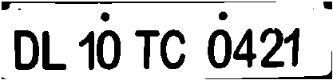

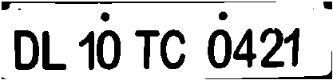

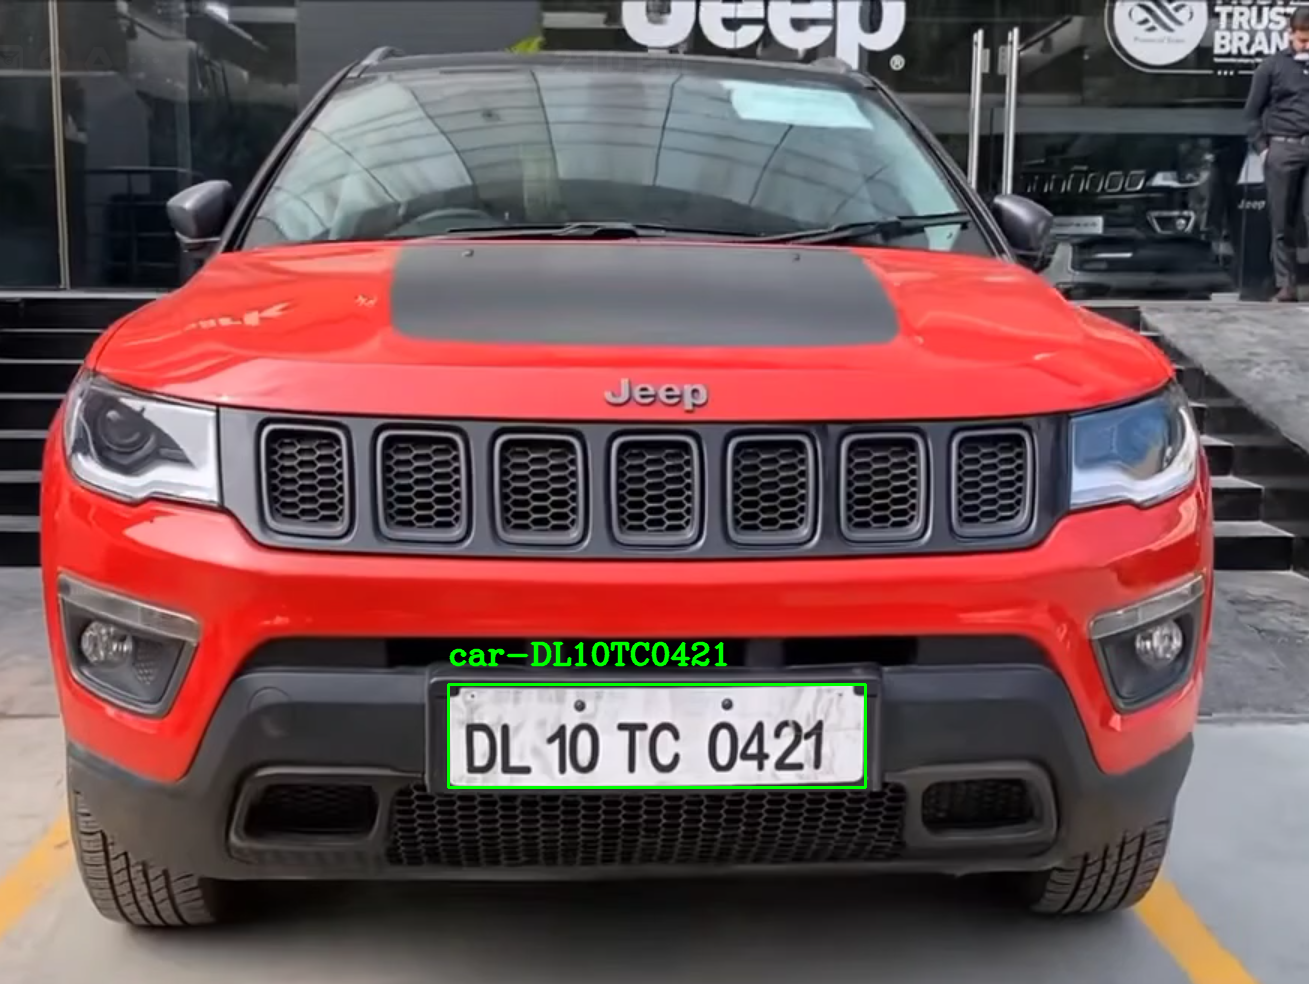

In [69]:
image = cv2.imread(dir+'/jeeep.png')
# image = cv2.imread(dir+'/car_.jpg')
image_dil = image.copy()
gray = cv2.cvtColor(image_dil, 
                        cv2.COLOR_BGR2GRAY)  
gray = cv2.bilateralFilter(gray, 11, 17, 17)  
edged = cv2.Canny(gray, 30, 200)


contours,hrch = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
sorted_contours = sorted(contours,key = cv2.contourArea,reverse = True)[:3]
 
for cnt in sorted_contours:
  peri = cv2.arcLength(cnt, True)
  approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)
  if len(approx) == 4:  # Select the contour with 4 corners
    x,y,w,h = cv2.boundingRect(cnt)
    cv2.rectangle(image_dil, (x,y),(x+w,y+h),(0,255,0),2)
    if float(w)/float(h)<2:continue
    if float(w)/float(h)>5:continue
    output = image_dil[y:y+h,x:x+w]
    car_number = preprocessing(output)
    cv2.putText(image_dil, f"car-{car_number}",(x,y-20),cv2.FONT_HERSHEY_COMPLEX,1,(0,255,0),2,cv2.LINE_AA)
    cv2_imshow(image_dil)
    

In [62]:
def preprocessing(plate_img):
  #converting into hsv and then extracting into gray scale 
  # for even ilumination or lighting 
  # hue saturation value
  value = cv2.split(cv2.cvtColor(plate_img, cv2.COLOR_BGR2HSV))[2] 

  # # thresholding the image into binary and then extracting foreground and background by otsu
  ret, thresh = cv2.threshold(value, 0, 255, 
                            cv2.THRESH_BINARY_INV +
                            cv2.THRESH_OTSU)
  # # changing black to white and white to black 
  thresh = cv2.bitwise_not(thresh)
  # # resizing the whole image so that we can have a fixed shape and size 
  thresh = cv2.resize(thresh,(333,80))
  cv2_imshow(thresh)
  # # now calling  the segmentation function
  car_number = segmentation(thresh)
  cv2_imshow(thresh)
  return(car_number)
  

In [61]:
def segmentation(number_plate):
  car_number = ""


  # making a copy for showing purpose 
  dil_contour = number_plate.copy()


  # extracting the contours of the number plate 
  contours,hrch = cv2.findContours(number_plate,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
  
    # now sorting the contours according to their x axis
  sorted_contour = sorted(contours,key = lambda ctr:cv2.boundingRect(ctr)[0])

  for cnt in sorted_contour:
    # getting the corrdinates of the contours in form of rectangle 
    x,y,w,h = cv2.boundingRect(cnt)
 
    # conditions for selecting the contours 
    height,width = number_plate.shape
    if height / float(h) > 4: continue
    ratio = h/float(w)
    if ratio < .8: continue
    if width / float(w) > 35:continue
    area = (w*h)
    
    if area < 500: continue
    ch = number_plate[y-3:y+h+3, x-3:x+w+3]
    ch = cv2.bitwise_not(ch)
    ch = cv2.medianBlur(ch,3)
    ch = cv2.resize(ch,(28,28))
    ch = cv2.cvtColor(ch,cv2.COLOR_GRAY2BGR)
    ch_ = ch.reshape(1,28,28,3)
    result = answer_dict[np.argmax(model.predict(ch_))]
    car_number = car_number+result
  return(car_number)    
    
    


    # print(ch.shape)



In [38]:
from keras.models import load_model
model = load_model(dir+'/model.h5')

In [39]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 32)        55328     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 32)        409632    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 32)        409632    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)              

Training our own model for recognition of number plate


In [254]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
train_generator = train_datagen.flow_from_directory(
        dir+'/train',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28
        batch_size=1,
        class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
        dir+'/val',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28        batch_size=1,
        class_mode='categorical')

Found 883 images belonging to 36 classes.
Found 216 images belonging to 36 classes.


In [255]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
# stop = EarlyStopping(monitor = 'loss',mode = 'min', patience = 4)

In [256]:
model = Sequential()
model.add(Conv2D(32, (24,24), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (20,20), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (20,20), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.00001), metrics=['accuracy'])

In [257]:
batch_size = 1
model.fit_generator(
      train_generator,
      steps_per_epoch = train_generator.samples // batch_size,
      validation_data = validation_generator, 
      validation_steps = validation_generator.samples // batch_size,verbose = 1,
      epochs = 80)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/80
  6/883 [..............................] - ETA: 12:23 - loss: 3.5959 - accuracy: 0.0000e+00

KeyboardInterrupt: ignored

In [ ]:
model.save(dir+'/model.h5')